In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.4.0 True
2.4.0
10.1
GCC 7.3


In [2]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class LotteDataset(CustomDataset):

    CLASSES = ('ID_gum', 'buttering', 'couque_coffee', 'chocopie', 'cidar', 
               'couque_white', 'coke', 'diget_ori', 'diget_choco', 'gumi_gumi', 
               'homerunball', 'jjolbyung_noodle', 'juicyfresh', 'jjolbyung_ori', 
               'spearmint', 'squid_peanut', 'samdasu', 'tuna', 'toreta', 
               'vita500', 'welchs', 'zec')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('JPEGImages', 'Annotations')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[1:]] for x in content]

            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

In [3]:
from mmcv import Config
cfg = Config.fromfile('./mmdetection/configs/ssd/ssd300_coco.py')

In [4]:
from mmdet.apis import set_random_seed

cfg.dataset_type = 'LotteDataset'
cfg.data_root = 'lotte_data/'

cfg.data.test.type = 'LotteDataset'
cfg.data.test.data_root = 'lotte_data/'
cfg.data.test.ann_file = 'train.txt'
cfg.data.test.img_prefix = 'training/JPEGImages'

cfg.data.train.dataset.type = 'LotteDataset'
cfg.data.train.dataset.data_root = 'lotte_data/'
cfg.data.train.dataset.ann_file = 'train.txt'
cfg.data.train.dataset.img_prefix = 'training/JPEGImages'

cfg.data.val.type = 'LotteDataset'
cfg.data.val.data_root = 'lotte_data/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/JPEGImages'

# num classes of the model in box head
cfg.model.bbox_head.num_classes = 22
cfg.load_from = 'checkpoints/ssd300_coco_20200307-a92d2092.pth'
cfg.work_dir = './tutorial_exps'

# original learning rate는 GPU가 8개이므로, 자신의 GPU의 개수에 맞게 변형
cfg.optimizer.lr = 0.02 / 8 # 한 개만 쓸거니까
cfg.log_config.interval = 10

cfg.evaluation.metric = 'mAP'
# set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# ㄴet seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

print(f'Config:\n{cfg.pretty_text}')

Config:
input_size = 300
model = dict(
    type='SingleStageDetector',
    pretrained='open-mmlab://vgg16_caffe',
    backbone=dict(
        type='SSDVGG',
        input_size=300,
        depth=16,
        with_last_pool=False,
        ceil_mode=True,
        out_indices=(3, 4),
        out_feature_indices=(22, 34),
        l2_norm_scale=20),
    neck=None,
    bbox_head=dict(
        type='SSDHead',
        in_channels=(512, 1024, 512, 256, 256, 256),
        num_classes=22,
        anchor_generator=dict(
            type='SSDAnchorGenerator',
            scale_major=False,
            input_size=300,
            basesize_ratio_range=(0.15, 0.9),
            strides=[8, 16, 32, 64, 100, 300],
            ratios=[[2], [2, 3], [2, 3], [2, 3], [2], [2]]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[0.1, 0.1, 0.2, 0.2])))
cudnn_benchmark = True
train_cfg = dict(
    assigner=dict(
        type='Max

In [5]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# dataset 구축
datasets = [build_dataset(cfg.data.train)]

# detector 구축
model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
model.CLASSES = datasets[0].CLASSES

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

2020-09-27 20:25:46,998 - mmdet - INFO - load model from: open-mmlab://vgg16_caffe
2020-09-27 20:25:47,034 - mmdet - WARNING - The model and loaded state dict do not match exactly

missing keys in source state_dict: extra.0.weight, extra.0.bias, extra.1.weight, extra.1.bias, extra.2.weight, extra.2.bias, extra.3.weight, extra.3.bias, extra.4.weight, extra.4.bias, extra.5.weight, extra.5.bias, extra.6.weight, extra.6.bias, extra.7.weight, extra.7.bias, l2_norm.weight

2020-09-27 20:25:54,179 - mmdet - INFO - load checkpoint from checkpoints/ssd300_coco_20200307-a92d2092.pth
2020-09-27 20:25:54,228 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.cls_convs.0.weight: copying a param with shape torch.Size([324, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([92, 512, 3, 3]).
size mismatch for bbox_head.cls_convs.0.bias: copying a param with shape torch.Size([324]) from checkpoint, the shape in current model is torc

2020-09-27 20:27:19,991 - mmdet - INFO - Epoch [1][300/734]	lr: 1.496e-03, eta: 1:22:21, time: 0.264, data_time: 0.018, memory: 1639, loss_cls: 4.2179, loss_bbox: 0.4261, loss: 4.6440
2020-09-27 20:27:22,612 - mmdet - INFO - Epoch [1][310/734]	lr: 1.546e-03, eta: 1:22:06, time: 0.262, data_time: 0.018, memory: 1639, loss_cls: 4.3198, loss_bbox: 0.4805, loss: 4.8002
2020-09-27 20:27:25,259 - mmdet - INFO - Epoch [1][320/734]	lr: 1.596e-03, eta: 1:21:52, time: 0.265, data_time: 0.019, memory: 1639, loss_cls: 4.0969, loss_bbox: 0.4595, loss: 4.5564
2020-09-27 20:27:27,894 - mmdet - INFO - Epoch [1][330/734]	lr: 1.646e-03, eta: 1:21:38, time: 0.264, data_time: 0.018, memory: 1639, loss_cls: 3.9374, loss_bbox: 0.4621, loss: 4.3995
2020-09-27 20:27:30,527 - mmdet - INFO - Epoch [1][340/734]	lr: 1.696e-03, eta: 1:21:25, time: 0.263, data_time: 0.018, memory: 1639, loss_cls: 3.7726, loss_bbox: 0.4592, loss: 4.2318
2020-09-27 20:27:33,158 - mmdet - INFO - Epoch [1][350/734]	lr: 1.746e-03, eta: 

2020-09-27 20:29:22,521 - mmdet - INFO - Epoch [2][20/734]	lr: 2.500e-03, eta: 1:17:11, time: 0.263, data_time: 0.019, memory: 1639, loss_cls: 2.5312, loss_bbox: 0.4084, loss: 2.9396
2020-09-27 20:29:25,163 - mmdet - INFO - Epoch [2][30/734]	lr: 2.500e-03, eta: 1:17:06, time: 0.264, data_time: 0.019, memory: 1639, loss_cls: 2.3848, loss_bbox: 0.4167, loss: 2.8016
2020-09-27 20:29:27,795 - mmdet - INFO - Epoch [2][40/734]	lr: 2.500e-03, eta: 1:17:00, time: 0.263, data_time: 0.018, memory: 1639, loss_cls: 2.5843, loss_bbox: 0.4318, loss: 3.0161
2020-09-27 20:29:30,447 - mmdet - INFO - Epoch [2][50/734]	lr: 2.500e-03, eta: 1:16:56, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 2.5128, loss_bbox: 0.4257, loss: 2.9384
2020-09-27 20:29:33,083 - mmdet - INFO - Epoch [2][60/734]	lr: 2.500e-03, eta: 1:16:51, time: 0.263, data_time: 0.018, memory: 1639, loss_cls: 2.6184, loss_bbox: 0.4685, loss: 3.0869
2020-09-27 20:29:35,733 - mmdet - INFO - Epoch [2][70/734]	lr: 2.500e-03, eta: 1:16:4

2020-09-27 20:31:21,619 - mmdet - INFO - Epoch [2][470/734]	lr: 2.500e-03, eta: 1:14:06, time: 0.265, data_time: 0.019, memory: 1639, loss_cls: 1.8546, loss_bbox: 0.3419, loss: 2.1965
2020-09-27 20:31:24,269 - mmdet - INFO - Epoch [2][480/734]	lr: 2.500e-03, eta: 1:14:02, time: 0.265, data_time: 0.019, memory: 1639, loss_cls: 1.9632, loss_bbox: 0.3476, loss: 2.3108
2020-09-27 20:31:26,921 - mmdet - INFO - Epoch [2][490/734]	lr: 2.500e-03, eta: 1:13:59, time: 0.265, data_time: 0.019, memory: 1639, loss_cls: 2.0229, loss_bbox: 0.3500, loss: 2.3729
2020-09-27 20:31:29,572 - mmdet - INFO - Epoch [2][500/734]	lr: 2.500e-03, eta: 1:13:55, time: 0.265, data_time: 0.019, memory: 1639, loss_cls: 1.9149, loss_bbox: 0.3982, loss: 2.3131
2020-09-27 20:31:32,224 - mmdet - INFO - Epoch [2][510/734]	lr: 2.500e-03, eta: 1:13:52, time: 0.265, data_time: 0.019, memory: 1639, loss_cls: 1.9235, loss_bbox: 0.3853, loss: 2.3088
2020-09-27 20:31:34,881 - mmdet - INFO - Epoch [2][520/734]	lr: 2.500e-03, eta: 

2020-09-27 20:33:24,234 - mmdet - INFO - Epoch [3][190/734]	lr: 2.500e-03, eta: 1:11:49, time: 0.263, data_time: 0.018, memory: 1639, loss_cls: 1.6983, loss_bbox: 0.3112, loss: 2.0095
2020-09-27 20:33:26,869 - mmdet - INFO - Epoch [3][200/734]	lr: 2.500e-03, eta: 1:11:46, time: 0.264, data_time: 0.019, memory: 1639, loss_cls: 1.6974, loss_bbox: 0.3145, loss: 2.0119
2020-09-27 20:33:29,499 - mmdet - INFO - Epoch [3][210/734]	lr: 2.500e-03, eta: 1:11:42, time: 0.263, data_time: 0.018, memory: 1639, loss_cls: 1.6104, loss_bbox: 0.3268, loss: 1.9371
2020-09-27 20:33:32,130 - mmdet - INFO - Epoch [3][220/734]	lr: 2.500e-03, eta: 1:11:39, time: 0.263, data_time: 0.019, memory: 1639, loss_cls: 1.8261, loss_bbox: 0.3176, loss: 2.1436
2020-09-27 20:33:34,767 - mmdet - INFO - Epoch [3][230/734]	lr: 2.500e-03, eta: 1:11:36, time: 0.264, data_time: 0.019, memory: 1639, loss_cls: 1.5503, loss_bbox: 0.3009, loss: 1.8512
2020-09-27 20:33:37,414 - mmdet - INFO - Epoch [3][240/734]	lr: 2.500e-03, eta: 

2020-09-27 20:35:23,014 - mmdet - INFO - Epoch [3][640/734]	lr: 2.500e-03, eta: 1:09:27, time: 0.264, data_time: 0.019, memory: 1639, loss_cls: 1.5226, loss_bbox: 0.3121, loss: 1.8347
2020-09-27 20:35:25,662 - mmdet - INFO - Epoch [3][650/734]	lr: 2.500e-03, eta: 1:09:24, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 1.6306, loss_bbox: 0.3588, loss: 1.9894
2020-09-27 20:35:28,305 - mmdet - INFO - Epoch [3][660/734]	lr: 2.500e-03, eta: 1:09:21, time: 0.264, data_time: 0.018, memory: 1639, loss_cls: 1.5800, loss_bbox: 0.3368, loss: 1.9168
2020-09-27 20:35:30,953 - mmdet - INFO - Epoch [3][670/734]	lr: 2.500e-03, eta: 1:09:18, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 1.4527, loss_bbox: 0.2857, loss: 1.7384
2020-09-27 20:35:33,584 - mmdet - INFO - Epoch [3][680/734]	lr: 2.500e-03, eta: 1:09:15, time: 0.263, data_time: 0.018, memory: 1639, loss_cls: 1.3969, loss_bbox: 0.2945, loss: 1.6913
2020-09-27 20:35:36,223 - mmdet - INFO - Epoch [3][690/734]	lr: 2.500e-03, eta: 

2020-09-27 20:37:25,289 - mmdet - INFO - Epoch [4][360/734]	lr: 2.500e-03, eta: 1:07:20, time: 0.263, data_time: 0.018, memory: 1639, loss_cls: 1.3696, loss_bbox: 0.2980, loss: 1.6676
2020-09-27 20:37:27,928 - mmdet - INFO - Epoch [4][370/734]	lr: 2.500e-03, eta: 1:07:18, time: 0.264, data_time: 0.018, memory: 1639, loss_cls: 1.3551, loss_bbox: 0.3192, loss: 1.6743
2020-09-27 20:37:30,559 - mmdet - INFO - Epoch [4][380/734]	lr: 2.500e-03, eta: 1:07:15, time: 0.263, data_time: 0.018, memory: 1639, loss_cls: 1.4525, loss_bbox: 0.3376, loss: 1.7901
2020-09-27 20:37:33,197 - mmdet - INFO - Epoch [4][390/734]	lr: 2.500e-03, eta: 1:07:12, time: 0.264, data_time: 0.019, memory: 1639, loss_cls: 1.4527, loss_bbox: 0.3073, loss: 1.7600
2020-09-27 20:37:35,833 - mmdet - INFO - Epoch [4][400/734]	lr: 2.500e-03, eta: 1:07:09, time: 0.263, data_time: 0.018, memory: 1639, loss_cls: 1.4771, loss_bbox: 0.2828, loss: 1.7599
2020-09-27 20:37:38,480 - mmdet - INFO - Epoch [4][410/734]	lr: 2.500e-03, eta: 

2020-09-27 20:39:27,659 - mmdet - INFO - Epoch [5][80/734]	lr: 2.500e-03, eta: 1:05:16, time: 0.263, data_time: 0.018, memory: 1639, loss_cls: 1.2610, loss_bbox: 0.2687, loss: 1.5297
2020-09-27 20:39:30,292 - mmdet - INFO - Epoch [5][90/734]	lr: 2.500e-03, eta: 1:05:13, time: 0.263, data_time: 0.019, memory: 1639, loss_cls: 1.2789, loss_bbox: 0.2653, loss: 1.5442
2020-09-27 20:39:32,925 - mmdet - INFO - Epoch [5][100/734]	lr: 2.500e-03, eta: 1:05:10, time: 0.263, data_time: 0.019, memory: 1639, loss_cls: 1.2552, loss_bbox: 0.2575, loss: 1.5127
2020-09-27 20:39:35,558 - mmdet - INFO - Epoch [5][110/734]	lr: 2.500e-03, eta: 1:05:07, time: 0.263, data_time: 0.018, memory: 1639, loss_cls: 1.2860, loss_bbox: 0.2547, loss: 1.5406
2020-09-27 20:39:38,197 - mmdet - INFO - Epoch [5][120/734]	lr: 2.500e-03, eta: 1:05:04, time: 0.264, data_time: 0.018, memory: 1639, loss_cls: 1.3251, loss_bbox: 0.2657, loss: 1.5907
2020-09-27 20:39:40,835 - mmdet - INFO - Epoch [5][130/734]	lr: 2.500e-03, eta: 1:

2020-09-27 20:41:26,487 - mmdet - INFO - Epoch [5][530/734]	lr: 2.500e-03, eta: 1:03:07, time: 0.263, data_time: 0.018, memory: 1639, loss_cls: 1.2039, loss_bbox: 0.2385, loss: 1.4424
2020-09-27 20:41:29,135 - mmdet - INFO - Epoch [5][540/734]	lr: 2.500e-03, eta: 1:03:05, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 1.1815, loss_bbox: 0.2376, loss: 1.4191
2020-09-27 20:41:31,772 - mmdet - INFO - Epoch [5][550/734]	lr: 2.500e-03, eta: 1:03:02, time: 0.263, data_time: 0.018, memory: 1639, loss_cls: 1.2734, loss_bbox: 0.2603, loss: 1.5337
2020-09-27 20:41:34,414 - mmdet - INFO - Epoch [5][560/734]	lr: 2.500e-03, eta: 1:02:59, time: 0.264, data_time: 0.019, memory: 1639, loss_cls: 1.1398, loss_bbox: 0.2485, loss: 1.3883
2020-09-27 20:41:37,054 - mmdet - INFO - Epoch [5][570/734]	lr: 2.500e-03, eta: 1:02:56, time: 0.264, data_time: 0.018, memory: 1639, loss_cls: 1.2017, loss_bbox: 0.2526, loss: 1.4543
2020-09-27 20:41:39,691 - mmdet - INFO - Epoch [5][580/734]	lr: 2.500e-03, eta: 

2020-09-27 20:43:28,636 - mmdet - INFO - Epoch [6][250/734]	lr: 2.500e-03, eta: 1:01:04, time: 0.264, data_time: 0.019, memory: 1639, loss_cls: 1.1462, loss_bbox: 0.2403, loss: 1.3865
2020-09-27 20:43:31,269 - mmdet - INFO - Epoch [6][260/734]	lr: 2.500e-03, eta: 1:01:02, time: 0.263, data_time: 0.018, memory: 1639, loss_cls: 1.0285, loss_bbox: 0.2153, loss: 1.2438
2020-09-27 20:43:33,917 - mmdet - INFO - Epoch [6][270/734]	lr: 2.500e-03, eta: 1:00:59, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 1.0833, loss_bbox: 0.2398, loss: 1.3231
2020-09-27 20:43:36,558 - mmdet - INFO - Epoch [6][280/734]	lr: 2.500e-03, eta: 1:00:56, time: 0.264, data_time: 0.018, memory: 1639, loss_cls: 1.1183, loss_bbox: 0.2264, loss: 1.3448
2020-09-27 20:43:39,197 - mmdet - INFO - Epoch [6][290/734]	lr: 2.500e-03, eta: 1:00:53, time: 0.264, data_time: 0.019, memory: 1639, loss_cls: 1.0634, loss_bbox: 0.2337, loss: 1.2970
2020-09-27 20:43:41,826 - mmdet - INFO - Epoch [6][300/734]	lr: 2.500e-03, eta: 

2020-09-27 20:45:27,378 - mmdet - INFO - Epoch [6][700/734]	lr: 2.500e-03, eta: 0:58:59, time: 0.264, data_time: 0.019, memory: 1639, loss_cls: 1.1733, loss_bbox: 0.2375, loss: 1.4108
2020-09-27 20:45:30,021 - mmdet - INFO - Epoch [6][710/734]	lr: 2.500e-03, eta: 0:58:56, time: 0.264, data_time: 0.018, memory: 1639, loss_cls: 1.2828, loss_bbox: 0.2633, loss: 1.5461
2020-09-27 20:45:32,658 - mmdet - INFO - Epoch [6][720/734]	lr: 2.500e-03, eta: 0:58:53, time: 0.264, data_time: 0.018, memory: 1639, loss_cls: 1.1746, loss_bbox: 0.2408, loss: 1.4154
2020-09-27 20:45:35,288 - mmdet - INFO - Epoch [6][730/734]	lr: 2.500e-03, eta: 0:58:51, time: 0.263, data_time: 0.018, memory: 1639, loss_cls: 1.2240, loss_bbox: 0.2382, loss: 1.4623
2020-09-27 20:45:41,413 - mmdet - INFO - Epoch [7][10/734]	lr: 2.500e-03, eta: 0:58:51, time: 0.507, data_time: 0.260, memory: 1639, loss_cls: 1.1950, loss_bbox: 0.2505, loss: 1.4455
2020-09-27 20:45:44,036 - mmdet - INFO - Epoch [7][20/734]	lr: 2.500e-03, eta: 0:

2020-09-27 20:47:29,589 - mmdet - INFO - Epoch [7][420/734]	lr: 2.500e-03, eta: 0:56:57, time: 0.264, data_time: 0.018, memory: 1639, loss_cls: 1.0052, loss_bbox: 0.2429, loss: 1.2481
2020-09-27 20:47:32,219 - mmdet - INFO - Epoch [7][430/734]	lr: 2.500e-03, eta: 0:56:54, time: 0.263, data_time: 0.018, memory: 1639, loss_cls: 1.0958, loss_bbox: 0.2447, loss: 1.3405
2020-09-27 20:47:34,849 - mmdet - INFO - Epoch [7][440/734]	lr: 2.500e-03, eta: 0:56:52, time: 0.263, data_time: 0.019, memory: 1639, loss_cls: 1.0115, loss_bbox: 0.2233, loss: 1.2348
2020-09-27 20:47:37,489 - mmdet - INFO - Epoch [7][450/734]	lr: 2.500e-03, eta: 0:56:49, time: 0.264, data_time: 0.018, memory: 1639, loss_cls: 0.9746, loss_bbox: 0.1944, loss: 1.1691
2020-09-27 20:47:40,130 - mmdet - INFO - Epoch [7][460/734]	lr: 2.500e-03, eta: 0:56:46, time: 0.264, data_time: 0.019, memory: 1639, loss_cls: 1.0160, loss_bbox: 0.2274, loss: 1.2434
2020-09-27 20:47:42,766 - mmdet - INFO - Epoch [7][470/734]	lr: 2.500e-03, eta: 

2020-09-27 20:49:31,791 - mmdet - INFO - Epoch [8][140/734]	lr: 2.500e-03, eta: 0:54:55, time: 0.263, data_time: 0.018, memory: 1639, loss_cls: 1.0181, loss_bbox: 0.2262, loss: 1.2443
2020-09-27 20:49:34,445 - mmdet - INFO - Epoch [8][150/734]	lr: 2.500e-03, eta: 0:54:53, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 0.9691, loss_bbox: 0.2025, loss: 1.1717
2020-09-27 20:49:37,087 - mmdet - INFO - Epoch [8][160/734]	lr: 2.500e-03, eta: 0:54:50, time: 0.264, data_time: 0.018, memory: 1639, loss_cls: 1.0313, loss_bbox: 0.2105, loss: 1.2418
2020-09-27 20:49:39,731 - mmdet - INFO - Epoch [8][170/734]	lr: 2.500e-03, eta: 0:54:47, time: 0.264, data_time: 0.018, memory: 1639, loss_cls: 1.0628, loss_bbox: 0.2159, loss: 1.2786
2020-09-27 20:49:42,373 - mmdet - INFO - Epoch [8][180/734]	lr: 2.500e-03, eta: 0:54:45, time: 0.264, data_time: 0.019, memory: 1639, loss_cls: 1.0430, loss_bbox: 0.2204, loss: 1.2634
2020-09-27 20:49:45,010 - mmdet - INFO - Epoch [8][190/734]	lr: 2.500e-03, eta: 

2020-09-27 20:51:30,658 - mmdet - INFO - Epoch [8][590/734]	lr: 2.500e-03, eta: 0:52:52, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 0.9565, loss_bbox: 0.2250, loss: 1.1815
2020-09-27 20:51:33,296 - mmdet - INFO - Epoch [8][600/734]	lr: 2.500e-03, eta: 0:52:50, time: 0.264, data_time: 0.018, memory: 1639, loss_cls: 1.0475, loss_bbox: 0.2332, loss: 1.2807
2020-09-27 20:51:35,948 - mmdet - INFO - Epoch [8][610/734]	lr: 2.500e-03, eta: 0:52:47, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 0.9273, loss_bbox: 0.2085, loss: 1.1358
2020-09-27 20:51:38,587 - mmdet - INFO - Epoch [8][620/734]	lr: 2.500e-03, eta: 0:52:44, time: 0.264, data_time: 0.019, memory: 1639, loss_cls: 1.0734, loss_bbox: 0.2289, loss: 1.3023
2020-09-27 20:51:41,220 - mmdet - INFO - Epoch [8][630/734]	lr: 2.500e-03, eta: 0:52:42, time: 0.263, data_time: 0.018, memory: 1639, loss_cls: 0.9360, loss_bbox: 0.2092, loss: 1.1452
2020-09-27 20:51:43,860 - mmdet - INFO - Epoch [8][640/734]	lr: 2.500e-03, eta: 

2020-09-27 20:53:33,058 - mmdet - INFO - Epoch [9][310/734]	lr: 2.500e-03, eta: 0:50:52, time: 0.264, data_time: 0.018, memory: 1639, loss_cls: 0.9855, loss_bbox: 0.2415, loss: 1.2269
2020-09-27 20:53:35,699 - mmdet - INFO - Epoch [9][320/734]	lr: 2.500e-03, eta: 0:50:49, time: 0.264, data_time: 0.018, memory: 1639, loss_cls: 1.0357, loss_bbox: 0.2357, loss: 1.2714
2020-09-27 20:53:38,345 - mmdet - INFO - Epoch [9][330/734]	lr: 2.500e-03, eta: 0:50:46, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 0.9291, loss_bbox: 0.2198, loss: 1.1490
2020-09-27 20:53:40,980 - mmdet - INFO - Epoch [9][340/734]	lr: 2.500e-03, eta: 0:50:43, time: 0.264, data_time: 0.019, memory: 1639, loss_cls: 1.0280, loss_bbox: 0.2164, loss: 1.2444
2020-09-27 20:53:43,615 - mmdet - INFO - Epoch [9][350/734]	lr: 2.500e-03, eta: 0:50:41, time: 0.263, data_time: 0.018, memory: 1639, loss_cls: 0.9633, loss_bbox: 0.2042, loss: 1.1676
2020-09-27 20:53:46,255 - mmdet - INFO - Epoch [9][360/734]	lr: 2.500e-03, eta: 

2020-09-27 20:55:35,309 - mmdet - INFO - Epoch [10][30/734]	lr: 2.500e-03, eta: 0:48:50, time: 0.264, data_time: 0.018, memory: 1639, loss_cls: 0.9271, loss_bbox: 0.2003, loss: 1.1275
2020-09-27 20:55:37,956 - mmdet - INFO - Epoch [10][40/734]	lr: 2.500e-03, eta: 0:48:48, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 0.9545, loss_bbox: 0.2040, loss: 1.1586
2020-09-27 20:55:40,588 - mmdet - INFO - Epoch [10][50/734]	lr: 2.500e-03, eta: 0:48:45, time: 0.263, data_time: 0.018, memory: 1639, loss_cls: 0.9834, loss_bbox: 0.2233, loss: 1.2067
2020-09-27 20:55:43,231 - mmdet - INFO - Epoch [10][60/734]	lr: 2.500e-03, eta: 0:48:42, time: 0.264, data_time: 0.018, memory: 1639, loss_cls: 0.8827, loss_bbox: 0.2072, loss: 1.0899
2020-09-27 20:55:45,871 - mmdet - INFO - Epoch [10][70/734]	lr: 2.500e-03, eta: 0:48:40, time: 0.264, data_time: 0.018, memory: 1639, loss_cls: 1.1268, loss_bbox: 0.2260, loss: 1.3527
2020-09-27 20:55:48,506 - mmdet - INFO - Epoch [10][80/734]	lr: 2.500e-03, eta: 

2020-09-27 20:57:34,933 - mmdet - INFO - Epoch [10][480/734]	lr: 2.500e-03, eta: 0:46:50, time: 0.264, data_time: 0.018, memory: 1639, loss_cls: 0.9440, loss_bbox: 0.2004, loss: 1.1444
2020-09-27 20:57:37,579 - mmdet - INFO - Epoch [10][490/734]	lr: 2.500e-03, eta: 0:46:47, time: 0.264, data_time: 0.018, memory: 1639, loss_cls: 0.9133, loss_bbox: 0.2005, loss: 1.1137
2020-09-27 20:57:40,223 - mmdet - INFO - Epoch [10][500/734]	lr: 2.500e-03, eta: 0:46:44, time: 0.264, data_time: 0.019, memory: 1639, loss_cls: 0.9181, loss_bbox: 0.1954, loss: 1.1135
2020-09-27 20:57:42,874 - mmdet - INFO - Epoch [10][510/734]	lr: 2.500e-03, eta: 0:46:41, time: 0.265, data_time: 0.019, memory: 1639, loss_cls: 1.0753, loss_bbox: 0.2506, loss: 1.3259
2020-09-27 20:57:45,514 - mmdet - INFO - Epoch [10][520/734]	lr: 2.500e-03, eta: 0:46:39, time: 0.264, data_time: 0.018, memory: 1639, loss_cls: 1.0684, loss_bbox: 0.2376, loss: 1.3060
2020-09-27 20:57:48,163 - mmdet - INFO - Epoch [10][530/734]	lr: 2.500e-03,

2020-09-27 20:59:37,714 - mmdet - INFO - Epoch [11][200/734]	lr: 2.500e-03, eta: 0:44:49, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 0.9295, loss_bbox: 0.2016, loss: 1.1311
2020-09-27 20:59:40,355 - mmdet - INFO - Epoch [11][210/734]	lr: 2.500e-03, eta: 0:44:46, time: 0.264, data_time: 0.018, memory: 1639, loss_cls: 0.9652, loss_bbox: 0.2002, loss: 1.1654
2020-09-27 20:59:43,003 - mmdet - INFO - Epoch [11][220/734]	lr: 2.500e-03, eta: 0:44:44, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 0.9370, loss_bbox: 0.1988, loss: 1.1358
2020-09-27 20:59:45,646 - mmdet - INFO - Epoch [11][230/734]	lr: 2.500e-03, eta: 0:44:41, time: 0.264, data_time: 0.018, memory: 1639, loss_cls: 0.9802, loss_bbox: 0.1943, loss: 1.1745
2020-09-27 20:59:48,286 - mmdet - INFO - Epoch [11][240/734]	lr: 2.500e-03, eta: 0:44:38, time: 0.264, data_time: 0.018, memory: 1639, loss_cls: 0.9054, loss_bbox: 0.2122, loss: 1.1176
2020-09-27 20:59:50,943 - mmdet - INFO - Epoch [11][250/734]	lr: 2.500e-03,

2020-09-27 21:01:37,353 - mmdet - INFO - Epoch [11][650/734]	lr: 2.500e-03, eta: 0:42:48, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 0.8662, loss_bbox: 0.1851, loss: 1.0513
2020-09-27 21:01:40,005 - mmdet - INFO - Epoch [11][660/734]	lr: 2.500e-03, eta: 0:42:46, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 0.8816, loss_bbox: 0.1947, loss: 1.0763
2020-09-27 21:01:42,662 - mmdet - INFO - Epoch [11][670/734]	lr: 2.500e-03, eta: 0:42:43, time: 0.266, data_time: 0.019, memory: 1639, loss_cls: 0.9321, loss_bbox: 0.2052, loss: 1.1372
2020-09-27 21:01:45,306 - mmdet - INFO - Epoch [11][680/734]	lr: 2.500e-03, eta: 0:42:40, time: 0.264, data_time: 0.019, memory: 1639, loss_cls: 0.8913, loss_bbox: 0.2138, loss: 1.1051
2020-09-27 21:01:47,961 - mmdet - INFO - Epoch [11][690/734]	lr: 2.500e-03, eta: 0:42:38, time: 0.266, data_time: 0.019, memory: 1639, loss_cls: 0.8733, loss_bbox: 0.2059, loss: 1.0792
2020-09-27 21:01:50,611 - mmdet - INFO - Epoch [11][700/734]	lr: 2.500e-03,

2020-09-27 21:03:40,578 - mmdet - INFO - Epoch [12][370/734]	lr: 2.500e-03, eta: 0:40:48, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 0.8864, loss_bbox: 0.1988, loss: 1.0851
2020-09-27 21:03:43,233 - mmdet - INFO - Epoch [12][380/734]	lr: 2.500e-03, eta: 0:40:46, time: 0.266, data_time: 0.019, memory: 1639, loss_cls: 0.7906, loss_bbox: 0.1830, loss: 0.9735
2020-09-27 21:03:45,888 - mmdet - INFO - Epoch [12][390/734]	lr: 2.500e-03, eta: 0:40:43, time: 0.265, data_time: 0.019, memory: 1639, loss_cls: 0.9169, loss_bbox: 0.1928, loss: 1.1097
2020-09-27 21:03:48,547 - mmdet - INFO - Epoch [12][400/734]	lr: 2.500e-03, eta: 0:40:40, time: 0.266, data_time: 0.019, memory: 1639, loss_cls: 0.8736, loss_bbox: 0.2068, loss: 1.0804
2020-09-27 21:03:51,197 - mmdet - INFO - Epoch [12][410/734]	lr: 2.500e-03, eta: 0:40:38, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 0.8672, loss_bbox: 0.1799, loss: 1.0471
2020-09-27 21:03:53,859 - mmdet - INFO - Epoch [12][420/734]	lr: 2.500e-03,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 829/829, 48.1 task/s, elapsed: 17s, ETA:     0s

2020-09-27 21:05:37,510 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| ID_gum           | 300 | 406  | 0.987  | 0.986 |
| buttering        | 232 | 366  | 0.957  | 0.938 |
| couque_coffee    | 394 | 676  | 0.970  | 0.943 |
| chocopie         | 307 | 536  | 0.997  | 0.988 |
| cidar            | 346 | 601  | 0.994  | 0.976 |
| couque_white     | 346 | 608  | 0.957  | 0.924 |
| coke             | 364 | 642  | 0.984  | 0.967 |
| diget_ori        | 347 | 515  | 0.988  | 0.962 |
| diget_choco      | 431 | 715  | 0.991  | 0.971 |
| gumi_gumi        | 295 | 482  | 0.997  | 0.996 |
| homerunball      | 302 | 466  | 0.974  | 0.971 |
| jjolbyung_noodle | 339 | 561  | 0.997  | 0.994 |
| juicyfresh       | 372 | 677  | 0.984  | 0.945 |
| jjolbyung_ori    | 370 | 613  | 0.976  | 0.975 |
| spearmint        | 267 | 352  | 0.929  | 0.913 |
| squid_peanut     | 339 | 469  | 1.000 

2020-09-27 21:07:18,302 - mmdet - INFO - Epoch [13][370/734]	lr: 2.500e-03, eta: 0:37:33, time: 0.267, data_time: 0.018, memory: 1639, loss_cls: 0.8892, loss_bbox: 0.1928, loss: 1.0820
2020-09-27 21:07:21,059 - mmdet - INFO - Epoch [13][380/734]	lr: 2.500e-03, eta: 0:37:30, time: 0.276, data_time: 0.020, memory: 1639, loss_cls: 0.9005, loss_bbox: 0.1889, loss: 1.0894
2020-09-27 21:07:23,773 - mmdet - INFO - Epoch [13][390/734]	lr: 2.500e-03, eta: 0:37:27, time: 0.272, data_time: 0.019, memory: 1639, loss_cls: 0.8480, loss_bbox: 0.1914, loss: 1.0394
2020-09-27 21:07:26,457 - mmdet - INFO - Epoch [13][400/734]	lr: 2.500e-03, eta: 0:37:25, time: 0.269, data_time: 0.018, memory: 1639, loss_cls: 0.8859, loss_bbox: 0.1877, loss: 1.0736
2020-09-27 21:07:29,163 - mmdet - INFO - Epoch [13][410/734]	lr: 2.500e-03, eta: 0:37:22, time: 0.270, data_time: 0.018, memory: 1639, loss_cls: 0.8704, loss_bbox: 0.1934, loss: 1.0638
2020-09-27 21:07:31,821 - mmdet - INFO - Epoch [13][420/734]	lr: 2.500e-03,

2020-09-27 21:09:21,568 - mmdet - INFO - Epoch [14][90/734]	lr: 2.500e-03, eta: 0:35:32, time: 0.264, data_time: 0.018, memory: 1639, loss_cls: 0.8106, loss_bbox: 0.1874, loss: 0.9980
2020-09-27 21:09:24,219 - mmdet - INFO - Epoch [14][100/734]	lr: 2.500e-03, eta: 0:35:30, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 0.8263, loss_bbox: 0.1502, loss: 0.9765
2020-09-27 21:09:26,863 - mmdet - INFO - Epoch [14][110/734]	lr: 2.500e-03, eta: 0:35:27, time: 0.264, data_time: 0.019, memory: 1639, loss_cls: 0.8360, loss_bbox: 0.1878, loss: 1.0237
2020-09-27 21:09:29,521 - mmdet - INFO - Epoch [14][120/734]	lr: 2.500e-03, eta: 0:35:24, time: 0.266, data_time: 0.018, memory: 1639, loss_cls: 0.9998, loss_bbox: 0.2114, loss: 1.2111
2020-09-27 21:09:32,175 - mmdet - INFO - Epoch [14][130/734]	lr: 2.500e-03, eta: 0:35:21, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 0.8865, loss_bbox: 0.1887, loss: 1.0751
2020-09-27 21:09:34,833 - mmdet - INFO - Epoch [14][140/734]	lr: 2.500e-03, 

2020-09-27 21:11:20,990 - mmdet - INFO - Epoch [14][540/734]	lr: 2.500e-03, eta: 0:33:31, time: 0.266, data_time: 0.018, memory: 1639, loss_cls: 0.8829, loss_bbox: 0.2021, loss: 1.0849
2020-09-27 21:11:23,644 - mmdet - INFO - Epoch [14][550/734]	lr: 2.500e-03, eta: 0:33:29, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 0.7983, loss_bbox: 0.1735, loss: 0.9718
2020-09-27 21:11:26,297 - mmdet - INFO - Epoch [14][560/734]	lr: 2.500e-03, eta: 0:33:26, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 0.8439, loss_bbox: 0.1850, loss: 1.0289
2020-09-27 21:11:28,955 - mmdet - INFO - Epoch [14][570/734]	lr: 2.500e-03, eta: 0:33:23, time: 0.266, data_time: 0.018, memory: 1639, loss_cls: 0.9093, loss_bbox: 0.1904, loss: 1.0997
2020-09-27 21:11:31,607 - mmdet - INFO - Epoch [14][580/734]	lr: 2.500e-03, eta: 0:33:21, time: 0.265, data_time: 0.019, memory: 1639, loss_cls: 0.8141, loss_bbox: 0.1826, loss: 0.9967
2020-09-27 21:11:34,267 - mmdet - INFO - Epoch [14][590/734]	lr: 2.500e-03,

2020-09-27 21:13:23,973 - mmdet - INFO - Epoch [15][260/734]	lr: 2.500e-03, eta: 0:31:31, time: 0.266, data_time: 0.018, memory: 1639, loss_cls: 0.8985, loss_bbox: 0.1996, loss: 1.0982
2020-09-27 21:13:26,625 - mmdet - INFO - Epoch [15][270/734]	lr: 2.500e-03, eta: 0:31:28, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 0.8161, loss_bbox: 0.1885, loss: 1.0047
2020-09-27 21:13:29,276 - mmdet - INFO - Epoch [15][280/734]	lr: 2.500e-03, eta: 0:31:25, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 0.8268, loss_bbox: 0.1844, loss: 1.0112
2020-09-27 21:13:31,941 - mmdet - INFO - Epoch [15][290/734]	lr: 2.500e-03, eta: 0:31:23, time: 0.267, data_time: 0.019, memory: 1639, loss_cls: 0.7639, loss_bbox: 0.1735, loss: 0.9374
2020-09-27 21:13:34,601 - mmdet - INFO - Epoch [15][300/734]	lr: 2.500e-03, eta: 0:31:20, time: 0.266, data_time: 0.019, memory: 1639, loss_cls: 0.8902, loss_bbox: 0.1930, loss: 1.0832
2020-09-27 21:13:37,261 - mmdet - INFO - Epoch [15][310/734]	lr: 2.500e-03,

2020-09-27 21:15:23,648 - mmdet - INFO - Epoch [15][710/734]	lr: 2.500e-03, eta: 0:29:30, time: 0.266, data_time: 0.018, memory: 1639, loss_cls: 0.8716, loss_bbox: 0.1749, loss: 1.0465
2020-09-27 21:15:26,299 - mmdet - INFO - Epoch [15][720/734]	lr: 2.500e-03, eta: 0:29:27, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 0.9284, loss_bbox: 0.2063, loss: 1.1347
2020-09-27 21:15:28,946 - mmdet - INFO - Epoch [15][730/734]	lr: 2.500e-03, eta: 0:29:25, time: 0.265, data_time: 0.019, memory: 1639, loss_cls: 0.9266, loss_bbox: 0.2010, loss: 1.1276
2020-09-27 21:15:35,141 - mmdet - INFO - Epoch [16][10/734]	lr: 2.500e-03, eta: 0:29:22, time: 0.513, data_time: 0.266, memory: 1639, loss_cls: 0.8855, loss_bbox: 0.2068, loss: 1.0923
2020-09-27 21:15:37,796 - mmdet - INFO - Epoch [16][20/734]	lr: 2.500e-03, eta: 0:29:19, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 0.8606, loss_bbox: 0.1835, loss: 1.0442
2020-09-27 21:15:40,447 - mmdet - INFO - Epoch [16][30/734]	lr: 2.500e-03, et

2020-09-27 21:17:26,643 - mmdet - INFO - Epoch [16][430/734]	lr: 2.500e-03, eta: 0:27:29, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 0.7842, loss_bbox: 0.1606, loss: 0.9448
2020-09-27 21:17:29,298 - mmdet - INFO - Epoch [16][440/734]	lr: 2.500e-03, eta: 0:27:27, time: 0.266, data_time: 0.019, memory: 1639, loss_cls: 0.8065, loss_bbox: 0.1702, loss: 0.9767
2020-09-27 21:17:31,962 - mmdet - INFO - Epoch [16][450/734]	lr: 2.500e-03, eta: 0:27:24, time: 0.266, data_time: 0.019, memory: 1639, loss_cls: 0.8585, loss_bbox: 0.1862, loss: 1.0447
2020-09-27 21:17:34,626 - mmdet - INFO - Epoch [16][460/734]	lr: 2.500e-03, eta: 0:27:21, time: 0.266, data_time: 0.019, memory: 1639, loss_cls: 0.8286, loss_bbox: 0.2024, loss: 1.0310
2020-09-27 21:17:37,281 - mmdet - INFO - Epoch [16][470/734]	lr: 2.500e-03, eta: 0:27:19, time: 0.265, data_time: 0.019, memory: 1639, loss_cls: 0.8699, loss_bbox: 0.2054, loss: 1.0753
2020-09-27 21:17:39,934 - mmdet - INFO - Epoch [16][480/734]	lr: 2.500e-03,

2020-09-27 21:19:29,786 - mmdet - INFO - Epoch [17][150/734]	lr: 2.500e-04, eta: 0:25:28, time: 0.266, data_time: 0.019, memory: 1639, loss_cls: 0.7081, loss_bbox: 0.1434, loss: 0.8515
2020-09-27 21:19:32,446 - mmdet - INFO - Epoch [17][160/734]	lr: 2.500e-04, eta: 0:25:26, time: 0.266, data_time: 0.019, memory: 1639, loss_cls: 0.7223, loss_bbox: 0.1373, loss: 0.8596
2020-09-27 21:19:35,103 - mmdet - INFO - Epoch [17][170/734]	lr: 2.500e-04, eta: 0:25:23, time: 0.266, data_time: 0.018, memory: 1639, loss_cls: 0.7980, loss_bbox: 0.1453, loss: 0.9433
2020-09-27 21:19:37,766 - mmdet - INFO - Epoch [17][180/734]	lr: 2.500e-04, eta: 0:25:20, time: 0.266, data_time: 0.019, memory: 1639, loss_cls: 0.6697, loss_bbox: 0.1340, loss: 0.8037
2020-09-27 21:19:40,417 - mmdet - INFO - Epoch [17][190/734]	lr: 2.500e-04, eta: 0:25:18, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 0.7402, loss_bbox: 0.1423, loss: 0.8826
2020-09-27 21:19:43,075 - mmdet - INFO - Epoch [17][200/734]	lr: 2.500e-04,

2020-09-27 21:21:32,818 - mmdet - INFO - Epoch [17][600/734]	lr: 2.500e-04, eta: 0:23:29, time: 0.276, data_time: 0.019, memory: 1639, loss_cls: 0.6981, loss_bbox: 0.1391, loss: 0.8372
2020-09-27 21:21:35,530 - mmdet - INFO - Epoch [17][610/734]	lr: 2.500e-04, eta: 0:23:27, time: 0.271, data_time: 0.019, memory: 1639, loss_cls: 0.8062, loss_bbox: 0.1416, loss: 0.9478
2020-09-27 21:21:38,247 - mmdet - INFO - Epoch [17][620/734]	lr: 2.500e-04, eta: 0:23:24, time: 0.272, data_time: 0.019, memory: 1639, loss_cls: 0.7077, loss_bbox: 0.1299, loss: 0.8376
2020-09-27 21:21:40,954 - mmdet - INFO - Epoch [17][630/734]	lr: 2.500e-04, eta: 0:23:21, time: 0.271, data_time: 0.019, memory: 1639, loss_cls: 0.7149, loss_bbox: 0.1495, loss: 0.8644
2020-09-27 21:21:43,673 - mmdet - INFO - Epoch [17][640/734]	lr: 2.500e-04, eta: 0:23:19, time: 0.272, data_time: 0.020, memory: 1639, loss_cls: 0.7382, loss_bbox: 0.1437, loss: 0.8819
2020-09-27 21:21:46,512 - mmdet - INFO - Epoch [17][650/734]	lr: 2.500e-04,

2020-09-27 21:23:36,876 - mmdet - INFO - Epoch [18][320/734]	lr: 2.500e-04, eta: 0:21:29, time: 0.267, data_time: 0.018, memory: 1639, loss_cls: 0.7453, loss_bbox: 0.1306, loss: 0.8759
2020-09-27 21:23:39,546 - mmdet - INFO - Epoch [18][330/734]	lr: 2.500e-04, eta: 0:21:26, time: 0.267, data_time: 0.019, memory: 1639, loss_cls: 0.6962, loss_bbox: 0.1203, loss: 0.8165
2020-09-27 21:23:42,215 - mmdet - INFO - Epoch [18][340/734]	lr: 2.500e-04, eta: 0:21:23, time: 0.267, data_time: 0.019, memory: 1639, loss_cls: 0.6622, loss_bbox: 0.1307, loss: 0.7929
2020-09-27 21:23:44,881 - mmdet - INFO - Epoch [18][350/734]	lr: 2.500e-04, eta: 0:21:20, time: 0.267, data_time: 0.019, memory: 1639, loss_cls: 0.6260, loss_bbox: 0.1261, loss: 0.7521
2020-09-27 21:23:47,549 - mmdet - INFO - Epoch [18][360/734]	lr: 2.500e-04, eta: 0:21:18, time: 0.267, data_time: 0.019, memory: 1639, loss_cls: 0.6829, loss_bbox: 0.1331, loss: 0.8160
2020-09-27 21:23:50,225 - mmdet - INFO - Epoch [18][370/734]	lr: 2.500e-04,

2020-09-27 21:25:40,706 - mmdet - INFO - Epoch [19][40/734]	lr: 2.500e-04, eta: 0:19:27, time: 0.266, data_time: 0.019, memory: 1639, loss_cls: 0.6818, loss_bbox: 0.1317, loss: 0.8135
2020-09-27 21:25:43,369 - mmdet - INFO - Epoch [19][50/734]	lr: 2.500e-04, eta: 0:19:25, time: 0.266, data_time: 0.019, memory: 1639, loss_cls: 0.7054, loss_bbox: 0.1324, loss: 0.8377
2020-09-27 21:25:46,024 - mmdet - INFO - Epoch [19][60/734]	lr: 2.500e-04, eta: 0:19:22, time: 0.265, data_time: 0.018, memory: 1639, loss_cls: 0.6390, loss_bbox: 0.1276, loss: 0.7666
2020-09-27 21:25:48,692 - mmdet - INFO - Epoch [19][70/734]	lr: 2.500e-04, eta: 0:19:19, time: 0.267, data_time: 0.018, memory: 1639, loss_cls: 0.5744, loss_bbox: 0.1116, loss: 0.6860
2020-09-27 21:25:51,362 - mmdet - INFO - Epoch [19][80/734]	lr: 2.500e-04, eta: 0:19:17, time: 0.267, data_time: 0.019, memory: 1639, loss_cls: 0.6282, loss_bbox: 0.1269, loss: 0.7551
2020-09-27 21:25:54,018 - mmdet - INFO - Epoch [19][90/734]	lr: 2.500e-04, eta: 

2020-09-27 21:27:41,057 - mmdet - INFO - Epoch [19][490/734]	lr: 2.500e-04, eta: 0:17:27, time: 0.266, data_time: 0.018, memory: 1639, loss_cls: 0.6665, loss_bbox: 0.1219, loss: 0.7883
2020-09-27 21:27:43,729 - mmdet - INFO - Epoch [19][500/734]	lr: 2.500e-04, eta: 0:17:24, time: 0.267, data_time: 0.018, memory: 1639, loss_cls: 0.7021, loss_bbox: 0.1351, loss: 0.8372
2020-09-27 21:27:46,396 - mmdet - INFO - Epoch [19][510/734]	lr: 2.500e-04, eta: 0:17:22, time: 0.267, data_time: 0.019, memory: 1639, loss_cls: 0.6467, loss_bbox: 0.1500, loss: 0.7968
2020-09-27 21:27:49,059 - mmdet - INFO - Epoch [19][520/734]	lr: 2.500e-04, eta: 0:17:19, time: 0.266, data_time: 0.018, memory: 1639, loss_cls: 0.6722, loss_bbox: 0.1251, loss: 0.7973
2020-09-27 21:27:51,721 - mmdet - INFO - Epoch [19][530/734]	lr: 2.500e-04, eta: 0:17:16, time: 0.266, data_time: 0.019, memory: 1639, loss_cls: 0.6651, loss_bbox: 0.1305, loss: 0.7956
2020-09-27 21:27:54,380 - mmdet - INFO - Epoch [19][540/734]	lr: 2.500e-04,

2020-09-27 21:29:45,198 - mmdet - INFO - Epoch [20][210/734]	lr: 2.500e-04, eta: 0:15:26, time: 0.275, data_time: 0.019, memory: 1639, loss_cls: 0.6584, loss_bbox: 0.1244, loss: 0.7827
2020-09-27 21:29:47,863 - mmdet - INFO - Epoch [20][220/734]	lr: 2.500e-04, eta: 0:15:23, time: 0.266, data_time: 0.019, memory: 1639, loss_cls: 0.6785, loss_bbox: 0.1317, loss: 0.8103
2020-09-27 21:29:50,536 - mmdet - INFO - Epoch [20][230/734]	lr: 2.500e-04, eta: 0:15:21, time: 0.267, data_time: 0.019, memory: 1639, loss_cls: 0.7135, loss_bbox: 0.1255, loss: 0.8390
2020-09-27 21:29:53,217 - mmdet - INFO - Epoch [20][240/734]	lr: 2.500e-04, eta: 0:15:18, time: 0.268, data_time: 0.019, memory: 1639, loss_cls: 0.6747, loss_bbox: 0.1357, loss: 0.8104
2020-09-27 21:29:56,093 - mmdet - INFO - Epoch [20][250/734]	lr: 2.500e-04, eta: 0:15:15, time: 0.286, data_time: 0.019, memory: 1639, loss_cls: 0.6197, loss_bbox: 0.1085, loss: 0.7281
2020-09-27 21:29:58,919 - mmdet - INFO - Epoch [20][260/734]	lr: 2.500e-04,

2020-09-27 21:31:46,693 - mmdet - INFO - Epoch [20][660/734]	lr: 2.500e-04, eta: 0:13:26, time: 0.268, data_time: 0.018, memory: 1639, loss_cls: 0.6151, loss_bbox: 0.1153, loss: 0.7305
2020-09-27 21:31:49,375 - mmdet - INFO - Epoch [20][670/734]	lr: 2.500e-04, eta: 0:13:23, time: 0.268, data_time: 0.019, memory: 1639, loss_cls: 0.7560, loss_bbox: 0.1448, loss: 0.9007
2020-09-27 21:31:52,061 - mmdet - INFO - Epoch [20][680/734]	lr: 2.500e-04, eta: 0:13:20, time: 0.269, data_time: 0.018, memory: 1639, loss_cls: 0.6960, loss_bbox: 0.1418, loss: 0.8378
2020-09-27 21:31:54,724 - mmdet - INFO - Epoch [20][690/734]	lr: 2.500e-04, eta: 0:13:18, time: 0.267, data_time: 0.019, memory: 1639, loss_cls: 0.6372, loss_bbox: 0.1246, loss: 0.7618
2020-09-27 21:31:57,387 - mmdet - INFO - Epoch [20][700/734]	lr: 2.500e-04, eta: 0:13:15, time: 0.266, data_time: 0.018, memory: 1639, loss_cls: 0.7241, loss_bbox: 0.1406, loss: 0.8647
2020-09-27 21:32:00,057 - mmdet - INFO - Epoch [20][710/734]	lr: 2.500e-04,

2020-09-27 21:33:50,483 - mmdet - INFO - Epoch [21][380/734]	lr: 2.500e-04, eta: 0:11:24, time: 0.268, data_time: 0.018, memory: 1639, loss_cls: 0.6217, loss_bbox: 0.1213, loss: 0.7430
2020-09-27 21:33:53,152 - mmdet - INFO - Epoch [21][390/734]	lr: 2.500e-04, eta: 0:11:22, time: 0.267, data_time: 0.019, memory: 1639, loss_cls: 0.7189, loss_bbox: 0.1345, loss: 0.8534
2020-09-27 21:33:55,838 - mmdet - INFO - Epoch [21][400/734]	lr: 2.500e-04, eta: 0:11:19, time: 0.268, data_time: 0.019, memory: 1639, loss_cls: 0.6936, loss_bbox: 0.1384, loss: 0.8321
2020-09-27 21:33:58,513 - mmdet - INFO - Epoch [21][410/734]	lr: 2.500e-04, eta: 0:11:16, time: 0.267, data_time: 0.018, memory: 1639, loss_cls: 0.6036, loss_bbox: 0.1333, loss: 0.7368
2020-09-27 21:34:01,187 - mmdet - INFO - Epoch [21][420/734]	lr: 2.500e-04, eta: 0:11:14, time: 0.267, data_time: 0.019, memory: 1639, loss_cls: 0.7649, loss_bbox: 0.1389, loss: 0.9038
2020-09-27 21:34:03,849 - mmdet - INFO - Epoch [21][430/734]	lr: 2.500e-04,

2020-09-27 21:35:54,562 - mmdet - INFO - Epoch [22][100/734]	lr: 2.500e-04, eta: 0:09:23, time: 0.267, data_time: 0.018, memory: 1639, loss_cls: 0.6995, loss_bbox: 0.1289, loss: 0.8283
2020-09-27 21:35:57,221 - mmdet - INFO - Epoch [22][110/734]	lr: 2.500e-04, eta: 0:09:20, time: 0.266, data_time: 0.019, memory: 1639, loss_cls: 0.6798, loss_bbox: 0.1265, loss: 0.8063
2020-09-27 21:35:59,882 - mmdet - INFO - Epoch [22][120/734]	lr: 2.500e-04, eta: 0:09:17, time: 0.266, data_time: 0.018, memory: 1639, loss_cls: 0.7323, loss_bbox: 0.1264, loss: 0.8587
2020-09-27 21:36:02,536 - mmdet - INFO - Epoch [22][130/734]	lr: 2.500e-04, eta: 0:09:15, time: 0.266, data_time: 0.019, memory: 1639, loss_cls: 0.6400, loss_bbox: 0.1206, loss: 0.7606
2020-09-27 21:36:05,198 - mmdet - INFO - Epoch [22][140/734]	lr: 2.500e-04, eta: 0:09:12, time: 0.266, data_time: 0.018, memory: 1639, loss_cls: 0.6836, loss_bbox: 0.1347, loss: 0.8183
2020-09-27 21:36:07,870 - mmdet - INFO - Epoch [22][150/734]	lr: 2.500e-04,

2020-09-27 21:37:55,652 - mmdet - INFO - Epoch [22][550/734]	lr: 2.500e-04, eta: 0:07:22, time: 0.266, data_time: 0.018, memory: 1639, loss_cls: 0.7526, loss_bbox: 0.1313, loss: 0.8839
2020-09-27 21:37:58,335 - mmdet - INFO - Epoch [22][560/734]	lr: 2.500e-04, eta: 0:07:20, time: 0.268, data_time: 0.018, memory: 1639, loss_cls: 0.6195, loss_bbox: 0.1211, loss: 0.7406
2020-09-27 21:38:01,004 - mmdet - INFO - Epoch [22][570/734]	lr: 2.500e-04, eta: 0:07:17, time: 0.267, data_time: 0.019, memory: 1639, loss_cls: 0.6931, loss_bbox: 0.1326, loss: 0.8257
2020-09-27 21:38:03,683 - mmdet - INFO - Epoch [22][580/734]	lr: 2.500e-04, eta: 0:07:14, time: 0.268, data_time: 0.018, memory: 1639, loss_cls: 0.6295, loss_bbox: 0.1311, loss: 0.7606
2020-09-27 21:38:06,353 - mmdet - INFO - Epoch [22][590/734]	lr: 2.500e-04, eta: 0:07:12, time: 0.267, data_time: 0.018, memory: 1639, loss_cls: 0.7009, loss_bbox: 0.1447, loss: 0.8456
2020-09-27 21:38:09,027 - mmdet - INFO - Epoch [22][600/734]	lr: 2.500e-04,

2020-09-27 21:39:59,470 - mmdet - INFO - Epoch [23][270/734]	lr: 2.500e-05, eta: 0:05:21, time: 0.267, data_time: 0.018, memory: 1639, loss_cls: 0.5753, loss_bbox: 0.1183, loss: 0.6936
2020-09-27 21:40:02,154 - mmdet - INFO - Epoch [23][280/734]	lr: 2.500e-05, eta: 0:05:18, time: 0.268, data_time: 0.018, memory: 1639, loss_cls: 0.7115, loss_bbox: 0.1340, loss: 0.8455
2020-09-27 21:40:04,830 - mmdet - INFO - Epoch [23][290/734]	lr: 2.500e-05, eta: 0:05:15, time: 0.268, data_time: 0.019, memory: 1639, loss_cls: 0.6209, loss_bbox: 0.1127, loss: 0.7336
2020-09-27 21:40:07,489 - mmdet - INFO - Epoch [23][300/734]	lr: 2.500e-05, eta: 0:05:13, time: 0.266, data_time: 0.018, memory: 1639, loss_cls: 0.7314, loss_bbox: 0.1345, loss: 0.8659
2020-09-27 21:40:10,149 - mmdet - INFO - Epoch [23][310/734]	lr: 2.500e-05, eta: 0:05:10, time: 0.266, data_time: 0.018, memory: 1639, loss_cls: 0.6622, loss_bbox: 0.1190, loss: 0.7811
2020-09-27 21:40:12,826 - mmdet - INFO - Epoch [23][320/734]	lr: 2.500e-05,

2020-09-27 21:41:59,786 - mmdet - INFO - Epoch [23][720/734]	lr: 2.500e-05, eta: 0:03:20, time: 0.267, data_time: 0.019, memory: 1639, loss_cls: 0.6396, loss_bbox: 0.1152, loss: 0.7548
2020-09-27 21:42:02,448 - mmdet - INFO - Epoch [23][730/734]	lr: 2.500e-05, eta: 0:03:17, time: 0.266, data_time: 0.019, memory: 1639, loss_cls: 0.5797, loss_bbox: 0.1052, loss: 0.6848
2020-09-27 21:42:08,768 - mmdet - INFO - Epoch [24][10/734]	lr: 2.500e-05, eta: 0:03:14, time: 0.525, data_time: 0.273, memory: 1639, loss_cls: 0.7023, loss_bbox: 0.1265, loss: 0.8287
2020-09-27 21:42:11,435 - mmdet - INFO - Epoch [24][20/734]	lr: 2.500e-05, eta: 0:03:11, time: 0.267, data_time: 0.019, memory: 1639, loss_cls: 0.6589, loss_bbox: 0.1306, loss: 0.7895
2020-09-27 21:42:14,101 - mmdet - INFO - Epoch [24][30/734]	lr: 2.500e-05, eta: 0:03:08, time: 0.267, data_time: 0.019, memory: 1639, loss_cls: 0.6174, loss_bbox: 0.1162, loss: 0.7337
2020-09-27 21:42:16,763 - mmdet - INFO - Epoch [24][40/734]	lr: 2.500e-05, eta

2020-09-27 21:44:03,725 - mmdet - INFO - Epoch [24][440/734]	lr: 2.500e-05, eta: 0:01:18, time: 0.268, data_time: 0.018, memory: 1639, loss_cls: 0.6885, loss_bbox: 0.1269, loss: 0.8154
2020-09-27 21:44:06,409 - mmdet - INFO - Epoch [24][450/734]	lr: 2.500e-05, eta: 0:01:16, time: 0.268, data_time: 0.018, memory: 1639, loss_cls: 0.6865, loss_bbox: 0.1246, loss: 0.8111
2020-09-27 21:44:09,078 - mmdet - INFO - Epoch [24][460/734]	lr: 2.500e-05, eta: 0:01:13, time: 0.267, data_time: 0.018, memory: 1639, loss_cls: 0.6186, loss_bbox: 0.1194, loss: 0.7380
2020-09-27 21:44:11,750 - mmdet - INFO - Epoch [24][470/734]	lr: 2.500e-05, eta: 0:01:10, time: 0.267, data_time: 0.018, memory: 1639, loss_cls: 0.6990, loss_bbox: 0.1301, loss: 0.8291
2020-09-27 21:44:14,416 - mmdet - INFO - Epoch [24][480/734]	lr: 2.500e-05, eta: 0:01:08, time: 0.267, data_time: 0.018, memory: 1639, loss_cls: 0.6619, loss_bbox: 0.1251, loss: 0.7870
2020-09-27 21:44:17,089 - mmdet - INFO - Epoch [24][490/734]	lr: 2.500e-05,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 829/829, 48.6 task/s, elapsed: 17s, ETA:     0s

2020-09-27 21:45:39,911 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| ID_gum           | 300 | 338  | 0.987  | 0.986 |
| buttering        | 232 | 278  | 0.970  | 0.958 |
| couque_coffee    | 394 | 463  | 0.967  | 0.938 |
| chocopie         | 307 | 355  | 0.993  | 0.983 |
| cidar            | 346 | 436  | 0.994  | 0.985 |
| couque_white     | 346 | 451  | 0.942  | 0.913 |
| coke             | 364 | 422  | 0.984  | 0.978 |
| diget_ori        | 347 | 423  | 0.991  | 0.957 |
| diget_choco      | 431 | 491  | 0.981  | 0.969 |
| gumi_gumi        | 295 | 331  | 0.993  | 0.993 |
| homerunball      | 302 | 336  | 0.977  | 0.975 |
| jjolbyung_noodle | 339 | 423  | 0.997  | 0.994 |
| juicyfresh       | 372 | 489  | 0.987  | 0.955 |
| jjolbyung_ori    | 370 | 436  | 0.978  | 0.978 |
| spearmint        | 267 | 320  | 0.951  | 0.940 |
| squid_peanut     | 339 | 388  | 1.000 

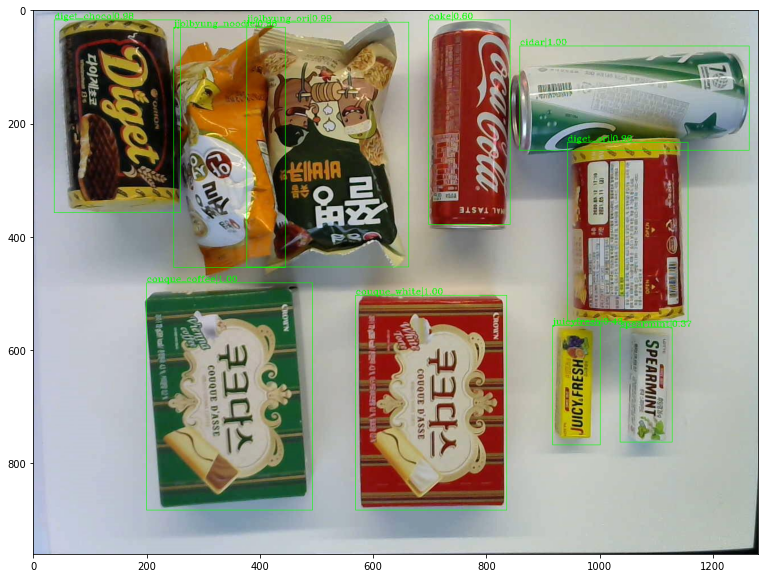

In [6]:
from mmdet.apis import inference_detector, show_result_pyplot
img = mmcv.imread('lotte_data/training/JPEGImages/0426.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

In [9]:
torch.save(model.state_dict(), 'state_dicts/SSD_model_state_dict')